In [1]:
import pandas as pd
import numpy as np
import os.path as op
import unicodedata
import sys
from gensim.models import FastText
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_predict, StratifiedShuffleSplit, train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier


basename = "/home/adrian/PhD/Tweet-Classification-Diabetes-Distress/"
path_utils = op.join(basename , "utils")
sys.path.insert(0, path_utils)

from sys_utils import load_library
from tweet_utils import *

from preprocess import Preprocess
prep = Preprocess()

model_we = FastText.load("/home/adrian/PhD/Data/FastText_embedding_20190703/ft_wordembeddings_dim300_minCount5_URL-User-toConstant_iter10_20190703")

trainingData = pd.read_csv("/home/adrian/PhD/Tweet-Classification-Diabetes-Distress/data/ManualLabels_sampleJokes.csv")#, usecols=["text", "user_description", "user_name", "user_screen_name", "HasDiabetes", 
#                            "Type_Diabetes", "Sexe", "History_HasDiab", "History_TypeDiab", "History_Sex"],
                           #converters={'user_description': lambda x: tt(x)}
                           #converters={'HasDiabetes': lambda x: int(x, 16)}
                          #dtype={'Type_Diabetes':np.int32}
 #                         )

trainingData.head(5)

[nltk_data] Downloading package punkt to /home/adrian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/adrian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/adrian/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/home/adrian/miniconda3/envs/deepscience/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


,id,text,user_description,user_name,user_screen_name,isJoke,get_diabetes
0,9.981736e+17,"@brostvles No, they don't. But if you wanna ge...","I write about broken people, outcasts, unusual...",J.S. Mueller,JSMueller_5150,0,NaN
1,9.755911e+17,@dougiec0n still shocked their reengagement di...,.,Sam,sgeezy99,1,NaN
2,1.083126e+18,❤️❤️diabetes here I come! https://t.co/afD4gjfQK5,NaN,sarah stewart,StewCrew3,1,NaN
3,1.089760e+18,@DenisJSM I don’t want diabetes but I do want ...,“Intelligence is proved not by ease of learnin...,Jennifer Lopez,Jennifer_guppy,1,NaN
4,9.360871e+17,i need a glucose guardian in my life https://t...,probs being rly gay somewhere. 👻 snap: tterbre...,brett,TT3RB,0,NaN


In [2]:
print("Vector size:", model_we.vector_size)
print("Vocab size:", len(model_we.wv.vocab))

Vector size: 300
Vocab size: 266230


In [3]:
def preprocess_tweet(tweet):
    tweet = prep.replace_hashtags_URL_USER(tweet, mode_URL="replace", mode_Mentions="replace")
    tweet = prep.tokenize(tweet)
    return tweet

def userName_to_vec(name):
    #print("name:", name)
    try:
        firstName = unicodedata.normalize('NFKD', name).encode('ascii', 'ignore').decode('utf-8', 'ignore').split(" ")[0].replace(" ", "")
        vec = model_we[firstName]
    except:
        vec = np.zeros((300, ))

    return vec

    
label = "isJoke"
data_pd = trainingData[["text", "user_description", "user_name", label]]

data_pd.text = data_pd.text.map(lambda tweet: tweet_vectorizer(preprocess_tweet(tweet), model_we))
data_pd.user_description = data_pd.user_description.map(lambda userDesc: np.zeros((300, )) 
                                                if isinstance(userDesc, float) or userDesc == " " 
                                                else tweet_vectorizer(preprocess_tweet(userDesc), model_we))    
data_pd.user_name = data_pd.user_name.map(userName_to_vec)

# remove the tweets that are empty because there is no word embedding
data_pd = data_pd[data_pd["text"].apply(lambda x: len(x) > 0) ]
print("size:", data_pd.shape)

data_pd.head(10)


/home/adrian/miniconda3/envs/deepscience/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


no embedding for ♏ !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for ⚣ !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for ♏ !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for 𝐬 !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for くコ !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for ♓ !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embe

/home/adrian/miniconda3/envs/deepscience/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


size: (998, 4)


,text,user_description,user_name,isJoke
0,"[0.13185108, 0.15854609, 0.059308123, -0.08474...","[0.14501965, 0.1639296, 0.014227675, -0.126300...","[0.21265264, 0.034552243, 0.15054181, 0.056686...",0
1,"[0.108976886, 0.023382073, -0.06781701, -0.064...","[0.19904195, 0.15107325, 0.043778256, -0.07146...","[0.10785165, -0.029285243, 0.28389975, 0.55538...",1
2,"[0.08293575, 0.17948663, 0.094873026, -0.16957...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.029924395, -0.046745047, -0.06653909, 0.794...",1
3,"[0.056647513, 0.18982013, 0.056503925, -0.1385...","[0.13530329, 0.09783886, 0.069970414, -0.11643...","[0.12648658, -0.11410462, -0.2413999, -0.28575...",1
4,"[0.09415601, 0.09907876, 0.14994046, -0.206853...","[0.070819035, 0.08872325, -0.0027138414, -0.15...","[-0.37360173, 0.008850073, -0.19633682, 0.3826...",0
5,"[0.13419962, 0.07032492, -0.019444106, -0.1686...","[0.13819365, 0.22996633, 0.09385859, -0.187312...","[-0.1846755, 0.2295045, 0.08000814, -0.0150846...",0
6,"[0.15829325, 0.009116557, 0.15179339, -0.14840...","[0.22600712, 0.12690334, -0.0035858839, -0.087...","[0.17596766, 0.21015534, 0.34056607, -0.139061...",0
7,"[0.12995987, 0.06622555, 0.32002127, -0.058351...","[0.08762968, 0.21612178, 0.044297133, -0.23825...","[0.19273165, 0.3860531, -0.007038169, 0.434332...",0
8,"[0.14556623, 0.09138066, -0.0066064894, -0.138...","[0.13576873, 0.040122155, 0.058657955, -0.1016...","[0.19317831, 0.26803303, 0.05705323, 0.1451025...",1
9,"[0.19313264, 0.042008042, 0.033570316, -0.1155...","[0.10193574, 0.028124692, 0.09347052, -0.06040...","[0.6075213, 0.054729555, 0.1304715, 0.3058847,...",1


In [42]:
class ItemSelect(BaseEstimator, TransformerMixin):
    
    def __init__(self, key):
        self.key = key
        
    def fit(self, x, y=None):
        return self
    
    def transform(self, data):
        #print("data: ", data.shape, type(data))
        #print("data[key]: ", data[self.key].shape, type(data[self.key]))
        #print("data[key].values: ", data[self.key].values.shape, type(data[self.key].values))
        #print("data[key].values.tolist: ", len(data[self.key].values.tolist()), type(data[self.key].values.tolist()))
        #print("asarray(data[key].values.tolist): ", np.asarray(data[self.key].values.tolist()).shape, type(np.asarray(data[self.key].values.tolist())))
        #print("data[key].head(): ", data[self.key].head())
        return np.asarray(data[self.key].values.tolist())
"""
class SMOTE_sampling(BaseEstimator, TransformerMixin):
    
    def __init__(self, key):
        self.key = key
        
    def fit(self, x, y=None):
        return self
    
    def transform(self, data):
        #print("data: ", data.shape, type(data))
        #print("data[key]: ", data[self.key].shape, type(data[self.key]))
        #print("data[key].values: ", data[self.key].values.shape, type(data[self.key].values))
        #print("data[key].values.tolist: ", len(data[self.key].values.tolist()), type(data[self.key].values.tolist()))
        #print("asarray(data[key].values.tolist): ", np.asarray(data[self.key].values.tolist()).shape, type(np.asarray(data[self.key].values.tolist())))
        #print("data[key].head(): ", data[self.key].head())
        return np.asarray(data[self.key].values.tolist())
"""
    
# choose algo:
#---------------------------------------------------------------------------
modelAlgo = "SVC"

if modelAlgo == "MultinomialNB":
    model = MultinomialNB(random_state=0)
elif modelAlgo == "SVC":
    model = SVC(random_state=0)
elif modelAlgo == "logReg":
    model = LogisticRegression(random_state=0)
elif modelAlgo == "RandomForest" :
    model = RandomForestClassifier(random_state=0)
elif modelAlgo == "XGBoost" :
    model = XGBClassifier(random_state=0)
elif modelAlgo == "MLP" :
    model = MLPClassifier(early_stopping=True, batch_size=32, random_state=0)
#model = KerasClassifier(build_fn=create_model, epochs=10)





from imblearn.pipeline import Pipeline
pipeline  = Pipeline([
                ('union', FeatureUnion(
                            transformer_list = [
                                ('tweet', Pipeline([
                                    ('tweetsSelector', ItemSelect(key='text')),
                                ])),  
                                ('userDesc', Pipeline([
                                    ('userDescSelector', ItemSelect(key='user_description'))
                                ])),
#                                ('userName', Pipeline([
#                                    ('userNameSelector', ItemSelect(key='user_name'))
#                                ]))
                                
                            ],
                )),
                ('smote', SMOTE(random_state=12, ratio = 1.0, n_jobs=-1)),
                ('model', model),
                #("debuggg", Debug("after model")),
            ])


# parameter grid for grid search by using fastText embeddings
parameters = {
                'union__transformer_weights' : [{"tweet": 1, "userDesc":0},
                                                {"tweet": 1, "userDesc":0.1}, 
                                                {"tweet": 1, "userDesc":0.2},
                                                #{"tweet": 1, "userDesc":0.3},
#                                                {"tweet": 1, "userDesc":1},
                                                ],
                'smote__k_neighbors' : [5, 6],


#               # param for SVC
               'model__kernel' : ["linear", "poly", "rbf"],
               'model__C' : [10.0, 5.0, 1.0, 0.1],
               'model__tol' : [1e-0, 1e-1],
#               'model__class_weight' : ["balanced", {1:1.0}, {1:1.1}],
#
#               # param for RandomForestClassifier
#               'model__n_estimators' : [50, 100, 150],
#               'model__criterion' : ['gini', 'entropy'],
#               'model__max_features' : ['auto', 'log2'],
#               'model__max_depth' : [ 5, 10, 20, 30]
 
                # param for XGBoost
#               'model__max_depth' : [3,4],
#               'model__learning_rate' : [0.01, 0.1, 0.5],
#               'model__booster' : ["gblinear"], #["gbtree", "gblinear", "dart"],
#               'model__gamma' : [0, 0.01],
#               'model__n_estimators' : [125, 150, 175],
#               'model__reg_alpha' : [0],#[0, 0.1],
#               'model__reg_lambda' : [0.1, 0.5, 1.0]
    
                 # param for Multi layer perceptron
#                 'model__hidden_layer_sizes' : [(32), (16), (32, 16)],
#                 'model__activation' : ['relu', 'tanh', 'logistic'],
#                 'model__solver' : ['adam', 'sgd', 'lbfgs'],
#                'model__learning_rate' : ['constant', 'invscaling'],
#                 'model__tol' : [ 1e-3, 1e-4],
                 #'model__alpha' : [ 1e-3, 1e-4, 1e-5],
#                  'model__max_iter' : [200, 300],
#                  'model__beta_1' : [0.990, 0.999],
#                  'model__beta_2' : [1e-7, 1e-8, 1e-9]
    
}


In [43]:
X = data_pd[["text", "user_description"]]
y = data_pd[label]
print("X :", X.shape, type(X))
print("y.unique: ", y.unique())
print(y.value_counts())
print(y.isnull().values.any())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0) 


#X_train_pd = pd.DataFrame(X_train_res, columns=["text", "user_description"])
#X_test_pd = pd.DataFrame(X_test, columns=["text", "user_description"])
X_train_pd = pd.DataFrame(X_train, columns=["text", "user_description"])
X_test_pd = pd.DataFrame(X_test, columns=["text", "user_description"])

    
print("Start Grid search...")
grid = GridSearchCV(pipeline, parameters, cv=10, n_jobs=-1, verbose=2, scoring="recall")#, scoring="roc_auc") # recall, f1, roc_auc
grid.fit(X_train_pd, y_train)
print("\nBest: %f using %s" % (grid.best_score_, grid.best_params_))

y_pred = grid.best_estimator_.predict(X_test_pd)
print("F1-Score:", f1_score(y_test, y_pred))
print("Precision: ",precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))    
print("Accuracy: ", accuracy_score(y_test, y_pred)) 
print("roc auc: ", roc_auc_score(y_test, y_pred))   
print("Performance overall: ")
print(classification_report(y_test, y_pred))



X : (998, 2) <class 'pandas.core.frame.DataFrame'>
y.unique:  [0 1]
0    748
1    250
Name: isJoke, dtype: int64
False
Start Grid search...
Fitting 10 folds for each of 144 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  5.3min finished
/home/adrian/miniconda3/envs/deepscience/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)



Best: 0.780781 using {'model__C': 0.1, 'model__kernel': 'linear', 'model__tol': 1.0, 'smote__k_neighbors': 6, 'union__transformer_weights': {'tweet': 1, 'userDesc': 0.1}}
F1-Score: 0.6766169154228856
Precision:  0.5666666666666667
Recall:  0.8395061728395061
Accuracy:  0.7833333333333333
roc auc:  0.8010316252325385
Performance overall: 
              precision    recall  f1-score   support

           0       0.93      0.76      0.84       219
           1       0.57      0.84      0.68        81

    accuracy                           0.78       300
   macro avg       0.75      0.80      0.76       300
weighted avg       0.83      0.78      0.79       300



In [ ]:
# SVC - SMOTE - Score default
Best: 0.803725 using {'model__C': 1.0, 'model__kernel': 'rbf', 'model__tol': 1.0, 'smote__k_neighbors': 5, 'union__transformer_weights': {'tweet': 1, 'userDesc': 0}}
F1-Score: 0.5
Precision:  0.7692307692307693
Recall:  0.37037037037037035
Accuracy:  0.8
roc auc:  0.6646372399797058
Performance overall: 
              precision    recall  f1-score   support

           0       0.80      0.96      0.88       219
           1       0.77      0.37      0.50        81

    accuracy                           0.80       300
   macro avg       0.79      0.66      0.69       300
weighted avg       0.80      0.80      0.77       300

    
# SVC - No SMOTE - Score default
Best: 0.812321 using {'model__C': 1.0, 'model__kernel': 'linear', 'model__tol': 0.1, 'union__transformer_weights': {'tweet': 1, 'userDesc': 0.4}}
F1-Score: 0.536231884057971
Precision:  0.6491228070175439
Recall:  0.4567901234567901
Accuracy:  0.7866666666666666
roc auc:  0.6827329612717741
Performance overall: 
              precision    recall  f1-score   support

           0       0.82      0.91      0.86       219
           1       0.65      0.46      0.54        81

    accuracy                           0.79       300
   macro avg       0.73      0.68      0.70       300
weighted avg       0.77      0.79      0.77       300


# SVC - No SMOTE - Score recall
Best: 0.425881 using {'model__C': 1.0, 'model__kernel': 'linear', 'model__tol': 1.0, 'union__transformer_weights': {'tweet': 1, 'userDesc': 0.4}}
F1-Score: 0.5633802816901409
Precision:  0.6557377049180327
Recall:  0.49382716049382713
Accuracy:  0.7933333333333333
roc auc:  0.6989683747674615
Performance overall: 
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       219
           1       0.66      0.49      0.56        81

    accuracy                           0.79       300
   macro avg       0.74      0.70      0.71       300
weighted avg       0.78      0.79      0.78       300

# SVC - SMOTE - Score recall
# BEST
Best: 0.780781 using {'model__C': 0.1, 'model__kernel': 'linear', 'model__tol': 1.0, 'smote__k_neighbors': 6, 'union__transformer_weights': {'tweet': 1, 'userDesc': 0.1}}
F1-Score: 0.6766169154228856
Precision:  0.5666666666666667
Recall:  0.8395061728395061
Accuracy:  0.7833333333333333
roc auc:  0.8010316252325385
Performance overall: 
              precision    recall  f1-score   support

           0       0.93      0.76      0.84       219
           1       0.57      0.84      0.68        81

    accuracy                           0.78       300
   macro avg       0.75      0.80      0.76       300
weighted avg       0.83      0.78      0.79       300



# XGBoost - SMOTE - 300 dim
Best: 0.685635 using {'model__booster': 'gblinear', 'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 125, 'model__reg_alpha': 0, 'model__reg_lambda': 0.5, 'smote__k_neighbors': 4, 'union__transformer_weights': {'tweet': 1, 'userDesc': 0.1}}
F1-Score: 0.6775956284153005
Precision:  0.6078431372549019
Recall:  0.7654320987654321
Accuracy:  0.8033333333333333
roc auc:  0.791391848469474
Performance overall: 
              precision    recall  f1-score   support

           0       0.90      0.82      0.86       219
           1       0.61      0.77      0.68        81

    accuracy                           0.80       300
   macro avg       0.76      0.79      0.77       300
weighted avg       0.82      0.80      0.81       300






OLD

# SVC - Smote - 300 - Score default
#Best: 0.815186 using {'model__C': 0.1, 'model__class_weight': {1: 0.5}, 'model__kernel': 'linear', 'model__tol': 0.1, 'smote__k_neighbors': 3, 'union__transformer_weights': {'tweet': 1, 'userDesc': 0}}
#F1-Score: 0.5499999999999999
#Precision:  0.8461538461538461
#Recall:  0.4074074074074074
#Accuracy:  0.82
#roc auc:  0.6900050735667174
#Performance overall: 
#              precision    recall  f1-score   support

#   (noJoke)0       0.82      0.97      0.89       219
#    (joke) 1       0.85      0.41      0.55        81

#   micro avg       0.82      0.82      0.82       300
#   macro avg       0.83      0.69      0.72       300
#weighted avg       0.82      0.82      0.80       300

# SVC - Smote oversampling - 200 dim vector - Score default (acc)
#Best: 0.805158 using {'model__C': 0.01, 'model__class_weight': 'balanced', 'model__kernel': 'linear', 'model__tol': 0.1, 'smote__k_neighbors': 5, 'union__transformer_weights': {'tweet': 1, 'userDesc': 0}}
#F1-Score: 0.6962025316455697
#Precision:  0.7142857142857143
#Recall:  0.6790123456790124
#Accuracy:  0.84
#roc auc:  0.7892778623372231
#Performance overall: 
#              precision    recall  f1-score   support

#   (noJoke)0       0.88      0.90      0.89       219
#    (joke) 1       0.71      0.68      0.70        81

#   micro avg       0.84      0.84      0.84       300
#   macro avg       0.80      0.79      0.79       300
#weighted avg       0.84      0.84      0.84       300

# SVC - Smote - 300 - Score recall
#Best: 0.815987 using {'model__C': 0.01, 'model__class_weight': 'balanced', 'model__kernel': 'linear', 'model__tol': 0.1, 'smote__k_neighbors': 8, 'union__transformer_weights': {'tweet': 1, 'userDesc': 0}}
#F1-Score: 0.6231155778894473
#Precision:  0.5254237288135594
#Recall:  0.7654320987654321
#Accuracy:  0.75
#roc auc:  0.7548621681041772
#Performance overall: 
#              precision    recall  f1-score   support

#           0       0.90      0.74      0.81       219
#           1       0.53      0.77      0.62        81

#   micro avg       0.75      0.75      0.75       300
#   macro avg       0.71      0.75      0.72       300
#weighted avg       0.80      0.75      0.76       300


# SVC - Smote oversampling - 200 dim vector - Score recall
#Best: 0.703712 using {'model__C': 0.5, 'model__kernel': 'linear', 'model__tol': 0.1, 'smote__k_neighbors': 5, 'union__transformer_weights': {'tweet': 1, 'userDesc': 0.2}}
#F1-Score: 0.6810810810810811
#Precision:  0.6057692307692307
#Recall:  0.7777777777777778
#Accuracy:  0.8033333333333333
#roc auc:  0.7952815829528159
#Performance overall: 
#              precision    recall  f1-score   support

#           0       0.91      0.81      0.86       219  (nojoke)
#           1       0.61      0.78      0.68        81  (joke)

#   micro avg       0.80      0.80      0.80       300
#   macro avg       0.76      0.80      0.77       300
#weighted avg       0.83      0.80      0.81       300


# XGBoost - SMOTE - 300 dim - score default
#Best: 0.767908 using {'model__booster': 'gblinear', 'model__learning_rate': 0.001, 'model__max_depth': 3, 'model__n_estimators': 80, 'smote__k_neighbors': 5, 'union__transformer_weights': {'tweet': 1, 'userDesc': 0}}
#F1-Score: 0.6493506493506493
#Precision:  0.684931506849315
#Recall:  0.6172839506172839
#Accuracy:  0.82
#roc auc:  0.7561305597835278
#Performance overall: 
#              precision    recall  f1-score   support

#           0       0.86      0.89      0.88       219
#           1       0.68      0.62      0.65        81

#   micro avg       0.82      0.82      0.82       300
#   macro avg       0.77      0.76      0.76       300
#weighted avg       0.82      0.82      0.82       300

# XGBoost - Smote - 300 score recall
#Best: 0.686015 using {'model__booster': 'gblinear', 'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 80, 'smote__k_neighbors': 8, 'union__transformer_weights': {'tweet': 1, 'userDesc': 0.2}}
#F1-Score: 0.6276595744680851
#Precision:  0.5514018691588785
#Recall:  0.7283950617283951
#Accuracy:  0.7666666666666667
#roc auc:  0.7546084897683072
#Performance overall: 
#              precision    recall  f1-score   support

#           0       0.89      0.78      0.83       219
#           1       0.55      0.73      0.63        81

#   micro avg       0.77      0.77      0.77       300
#   macro avg       0.72      0.75      0.73       300
#weighted avg       0.80      0.77      0.78       300


# XGBoost - Smote - 200 score recall
# Best: 0.685635 using {'model__booster': 'gblinear', 'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 150, 'smote__k_neighbors': 5, 'union__transformer_weights': {'tweet': 1, 'userDesc': 0.2}}
#F1-Score: 0.6740331491712707
#Precision:  0.61
#Recall:  0.7530864197530864
#Accuracy:  0.8033333333333333
#roc auc:  0.7875021139861322
#Performance overall: 
#              precision    recall  f1-score   support

#           0       0.90      0.82      0.86       219
#           1       0.61      0.75      0.67        81

#   micro avg       0.80      0.80      0.80       300
#   macro avg       0.76      0.79      0.77       300
#weighted avg       0.82      0.80      0.81       300

# SVC - Smote oversampling - 200 dim vector - Score recall
#Best: 0.703712 using {'model__C': 0.5, 'model__kernel': 'linear', 'model__tol': 0.1, 'smote__k_neighbors': 5, 'union__transformer_weights': {'tweet': 1, 'userDesc': 0.2}}
#F1-Score: 0.6810810810810811
#Precision:  0.6057692307692307
#Recall:  0.7777777777777778
#Accuracy:  0.8033333333333333
#roc auc:  0.7952815829528159
#Performance overall: 
#              precision    recall  f1-score   support

#           0       0.91      0.81      0.86       219  (nojoke)
#           1       0.61      0.78      0.68        81  (joke)

#   micro avg       0.80      0.80      0.80       300
#   macro avg       0.76      0.80      0.77       300
#weighted avg       0.83      0.80      0.81       300



Classes before: ['0' '1']
unique labels: [0 1]
Classes: ['0' '1']
Confusion matrix, without normalization
[[167  52]
 [ 13  68]]
Classes before: ['0' '1']
unique labels: [0 1]
Classes: ['0' '1']
Normalized confusion matrix
[[0.76 0.24]
 [0.16 0.84]]


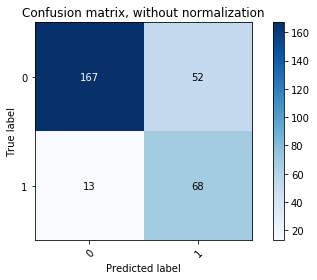

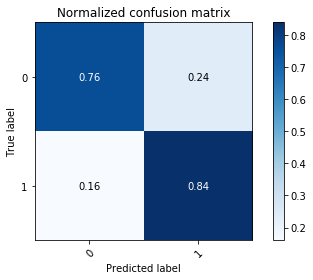

In [44]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    print("Classes before:", classes)
    print("unique labels:", unique_labels(y_true, y_pred))
    classes = classes[unique_labels(y_true, y_pred)]
    print("Classes:", classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax



np.set_printoptions(precision=2)

#class_names = np.array(["M", "F", "U"])
class_names = np.array(["0", "1"])

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [45]:
# OLD 
# SVC - Smote oversampling - 200 dim vector - Score recall
#Best: 0.703712 using {'model__C': 0.5, 'model__kernel': 'linear', 'model__tol': 0.1, 'smote__k_neighbors': 5, 'union__transformer_weights': {'tweet': 1, 'userDesc': 0.2}}
#F1-Score: 0.6810810810810811
#Precision:  0.6057692307692307
#Recall:  0.7777777777777778
#Accuracy:  0.8033333333333333
#roc auc:  0.7952815829528159
#Performance overall: 
#              precision    recall  f1-score   support

#           0       0.91      0.81      0.86       219  (nojoke)
#           1       0.61      0.78      0.68        81  (joke)

#   micro avg       0.80      0.80      0.80       300
#   macro avg       0.76      0.80      0.77       300
#weighted avg       0.83      0.80      0.81       300


# NEW 
# SVC - Smote oversampling - 300 dim vector - Score recall
#Best: 0.780781 using {'model__C': 0.1, 'model__kernel': 'linear', 'model__tol': 1.0, 'smote__k_neighbors': 6, 'union__transformer_weights': {'tweet': 1, 'userDesc': 0.1}}
#F1-Score: 0.6766169154228856
#Precision:  0.5666666666666667
#Recall:  0.8395061728395061
#Accuracy:  0.7833333333333333
#roc auc:  0.8010316252325385
#Performance overall:
#              precision    recall  f1-score   support

#           0       0.93      0.76      0.84       219
#           1       0.57      0.84      0.68        81

#    accuracy                           0.78       300
#   macro avg       0.75      0.80      0.76       300
#weighted avg       0.83      0.78      0.79       300



from sklearn.externals import joblib
from imblearn.pipeline import Pipeline


pipeline  = Pipeline([
                ('union', FeatureUnion(
                            transformer_list = [
                                ('tweet', Pipeline([ ('tweetsSelector', ItemSelect(key='text')) ])),  
                                ('userDesc', Pipeline([ ('userDescSelector', ItemSelect(key='user_description')) ])),  
                            ],
                )),
                ('smote', SMOTE(random_state=12, ratio = 1.0, n_jobs=-1)),
                ('model', model),
            ])


# parameter grid for grid search by using fastText embeddings
parameters = {
               'union__transformer_weights' : [{"tweet": 1, "userDesc":0.1}],
               'smote__k_neighbors' : [6],
               'model__kernel' : ["linear"],
               'model__C' : [0.1],
               'model__tol' : [1.0],
}
"""

# create best pipeline
best_pipeline = pipeline
best_pipeline.set_params(**parameters)

print("Train model...")
best_pipeline_trained = best_pipeline.fit(X_train_pd, y_train)

# save best model
print("Save model to {} ...".format("jokesClassifier_05042019.model"))
joblib.dump(best_pipeline_trained, "jokesClassifier_05042019.model")
"""

joblib.dump(grid.best_estimator_, "jokesClassifier_20190703.model")


print(grid.best_estimator_)

Pipeline(memory=None,
         steps=[('union',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('tweet',
                                                 Pipeline(memory=None,
                                                          steps=[('tweetsSelector',
                                                                  ItemSelect(key='text'))],
                                                          verbose=False)),
                                                ('userDesc',
                                                 Pipeline(memory=None,
                                                          steps=[('userDescSelector',
                                                                  ItemSelect(key='user_description'))],
                                                          verbose=False))],
                              transformer_weights={'tweet': 1, 'userDesc': 0.1},
                              verbose=False...
   

/home/adrian/miniconda3/envs/deepscience/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [13]:
from sklearn.externals import joblib

estim = joblib.load("jokesClassifier_05042019.model")
print(estim)

Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=None,
       transformer_list=[('tweet', Pipeline(memory=None, steps=[('tweetsSelector', ItemSelect(key='text'))])), ('userDesc', Pipeline(memory=None,
     steps=[('userDescSelector', ItemSelect(key='user_description'))]))],
       transformer_weights={'tweet': ...linear', max_iter=-1, probability=False, random_state=0,
  shrinking=True, tol=0.1, verbose=False))])


In [14]:
estim.predict(X_test_pd)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0])